# ENV / ATM 415: Climate Laboratory

# Radiative- and Radiative-Convective Equilibrium with `climlab`

Thursday March 31, 2016

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import climlab

____________

## Using `climlab` to implement the two-layer leaky greenhouse model
____________

One of the things that ``climlab`` is set up to do is the grey-radiation modeling we have already been discussing.

Since we already derived a complete analytical solution to the two-layer leaky greenhouse model, we will use this to validate the `climlab` code.


### Validation

We want to verify that the model reproduces the observed OLR given observed temperatures, and the absorptivity that we tuned in the analytical model. The target numbers are:

\begin{align}
T_s &= 288 \text{ K} \\
T_0 &= 275 \text{ K} \\
T_1 &= 230 \text{ K} \\
\end{align}

$$ \epsilon = 0.58377  $$

$$ OLR = 239 \text{ W m}^{-2} $$


### Initialize a model in `climlab`
The first thing we do is create a new model.

The following example code is sparsely commented but will hopefully orient you on the basics of defining and working with a `climlab Process` object.

In [50]:
#  Test in a 2-layer atmosphere
col = climlab.GreyRadiationModel(num_lev=2)
print col

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (2,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [51]:
col.state

{'Tatm': Field([ 200.,  278.]), 'Ts': Field([ 288.])}

In [52]:
col.Ts

Field([ 288.])

In [53]:
#  Set the temperatures to our observed values
col.Ts[:] = 288.
col.Tatm[:] = np.array([230., 275.])
col.state

{'Tatm': Field([ 230.,  275.]), 'Ts': Field([ 288.])}

In [54]:
LW = col.subprocess['LW']
print LW

climlab Process of type <class 'climlab.radiation.greygas.GreyGas'>. 
State variables and domain shapes: 
  Tatm: (2,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.radiation.greygas.GreyGas'>



In [55]:
LW.absorptivity

Field([ 0.47737425,  0.47737425])

In [56]:
#  Set the absorptivity to our tuned value
LW.absorptivity = 0.58377
LW.absorptivity

Field([ 0.58377,  0.58377])

In [57]:
#  This does all the calculations that would be performed at each time step, 
#  but doesn't actually update the temperatures
col.compute_diagnostics()
#  Let's see what's in the diagnostics dictionary
col.diagnostics

{'ASR': array([ 239.2513]),
 'LW_absorbed_atm': array([ 20.03935568, -96.82138041]),
 'LW_absorbed_sfc': 0.0,
 'LW_down_sfc': array([ 227.87116061]),
 'LW_emission': Field([  92.63278385,  189.31461699]),
 'LW_up_sfc': 0.0,
 'OLR': array([ 239.01589408]),
 'SW_absorbed_atm': array([ 0.,  0.]),
 'SW_absorbed_sfc': 0.0,
 'SW_down_TOA': array([ 341.3]),
 'SW_up_TOA': array([ 102.0487]),
 'SW_up_sfc': Field([ 102.0487]),
 'absorbed': array([ 0.,  0.]),
 'absorbed_total': 0.0,
 'emission': Field([ 0.,  0.]),
 'emission_sfc': Field([ 0.]),
 'flux_from_sfc': Field([ 102.0487]),
 'flux_reflected_up': array([   0.    ,    0.    ,  102.0487]),
 'flux_to_sfc': array([ 341.3]),
 'flux_to_space': array([ 102.0487]),
 'insolation': array([ 341.3]),
 'planetary_albedo': array([ 0.299])}

In [58]:
#  Check OLR against our analytical solution
col.OLR

array([ 239.01589408])

In [59]:
col.state

{'Tatm': Field([ 230.,  275.]), 'Ts': Field([ 288.])}

In [60]:
# perform a single time step
col.step_forward()

In [61]:
col.state

{'Tatm': Field([ 230.33800245,  273.36692033]), 'Ts': Field([ 289.59144429])}

In [62]:
# integrate out to radiative equilibrium
col.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 2.00141166601 years.


In [63]:
# Check for equilibrium
col.ASR - col.OLR

array([ -2.78206130e-07])

In [64]:
#  The temperatures at radiative equilibrium
col.state

{'Tatm': Field([ 233.62925791,  262.08988335]), 'Ts': Field([ 296.20384534])}

Compare these to the analytical solutions for radiative equilibrium with $\epsilon = 0.58$:

\begin{align}
T_1 &= 234 \text{ K} \\
T_0 &= 262 \text{ K} \\
T_s &= 296 \text{ K} \\
\end{align}


So it looks like `climlab` agrees with our analytical results. That's good.

____________

## The observed annual, global mean temperature profile
____________

We want to model the OLR in a column whose temperatures match observations. We'll calculate the global, annual mean air temperature from the NCEP Reanalysis data.

In [65]:
# This will try to read the data over the internet.
ncep_filename = 'air.mon.1981-2010.ltm.nc'
#ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
#ncep_air = nc.Dataset( ncep_url + 'pressure/' + ncep_filename )
# Or to read from local disk
ncep_air = nc.Dataset( ncep_filename )

level = ncep_air.variables['level'][:]
lat = ncep_air.variables['lat'][:]
# A log-pressure height coordinate
zstar = -np.log(level/1000)

In [66]:
#  Take averages of the temperature data
Tzon = np.mean(ncep_air.variables['air'][:],axis=(0,3))
Tglobal = np.average( Tzon , weights=np.cos(np.deg2rad(lat)), axis=1) + climlab.constants.tempCtoK
#  Note the useful conversion factor. climlab.constants has lots of commonly used constant pre-defined

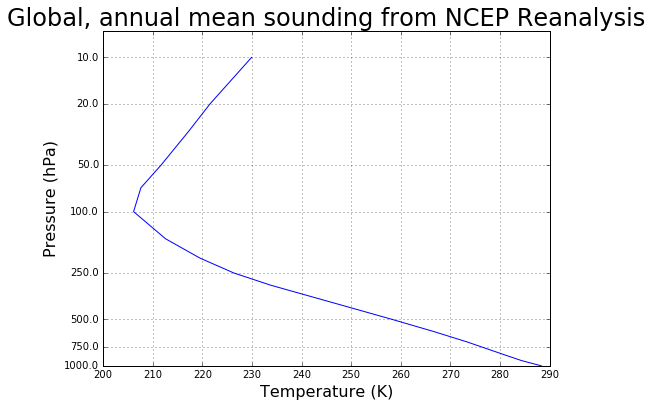

In [67]:
#  Here we are plotting with respect to log(pressure) but labeling the axis in pressure units
fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(111)
ax.plot( Tglobal , zstar )
yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10.])
ax.set_yticks(-np.log(yticks/1000.))
ax.set_yticklabels(yticks)
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_title('Global, annual mean sounding from NCEP Reanalysis', fontsize = 24)
ax.grid()

____________

## A 30-layer model using the observed temperatures
____________



In [68]:
#  initialize a grey radiation model with 30 levels
col = climlab.GreyRadiationModel()
print col

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [69]:
# interpolate to 30 evenly spaced pressure levels
lev = col.lev
Tinterp = np.interp(lev, np.flipud(level), np.flipud(Tglobal))

print Tinterp
#  Need to 'flipud' because the interpolation routine needs the pressure data to be in increasing order

[ 224.34736633  211.66334534  206.96233453  208.29142761  212.58644104
  217.19397481  221.78252157  226.3520813   231.30422974  236.08017476
  240.67991638  245.279658    249.35979716  252.92033386  256.48087056
  259.66789246  262.48139954  265.29490662  267.81303914  270.03579712
  272.25855509  274.21642049  275.90939331  277.60236613  279.29533895
  280.98831177  282.48550415  283.98269653  285.6810201   287.4463874 ]


In [70]:
# Initialize model with observed temperatures
col.Ts[:] = Tglobal[0]
col.Tatm[:] = Tinterp

In [71]:
#  A handy re-usable routine for making a plot of the temperature profiles
#  We will plot temperatures with respect to log(pressure) to get a height-like coordinate
def plot_sounding(collist):
    color_cycle=['r', 'g', 'b', 'y']
    # col is either a column model object or a list of column model objects
    if isinstance(collist, climlab.Process):
        # make a list with a single item
        collist = [collist]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i, col in enumerate(collist):
        zstar = -np.log(col.lev/climlab.constants.ps)
        ax.plot(col.Tatm, zstar, color=color_cycle[i])
        ax.plot(col.Ts, 0, 'o', markersize=12, color=color_cycle[i])
    #ax.invert_yaxis()
    yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10.])
    ax.set_yticks(-np.log(yticks/1000.))
    ax.set_yticklabels(yticks)
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Pressure (hPa)')
    ax.grid()
    return ax

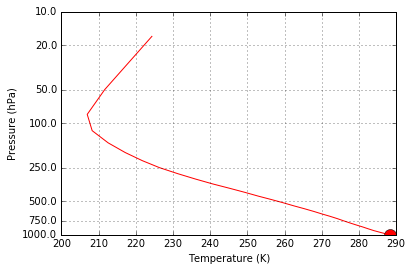

In [72]:
# This should look just like the observations
plot_sounding(col)

### Tune absorptivity to get observed OLR

In [73]:
col.compute_diagnostics()
col.OLR

array([ 263.15000167])

In [74]:
# Need to tune absorptivity to get OLR = 239
epsarray = np.linspace(0.01, 0.1, 100)
OLRarray = np.zeros_like(epsarray)

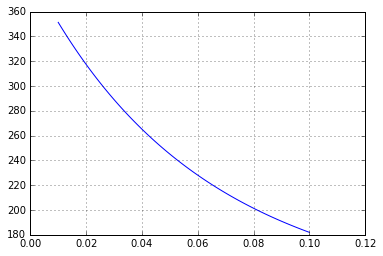

In [75]:
for i in range(epsarray.size):
    col.subprocess['LW'].absorptivity = epsarray[i]
    col.compute_diagnostics()
    OLRarray[i] = col.OLR

plt.plot(epsarray, OLRarray)
plt.grid()

The necessary value seems to lie near 0.055 or so.

A precise numerical search gives $\epsilon = 0.0534$

In [76]:
eps = 0.0534

col.subprocess.LW.absorptivity = eps
col.subprocess.LW.absorptivity

Field([ 0.0534,  0.0534,  0.0534,  0.0534,  0.0534,  0.0534,  0.0534,
        0.0534,  0.0534,  0.0534,  0.0534,  0.0534,  0.0534,  0.0534,
        0.0534,  0.0534,  0.0534,  0.0534,  0.0534,  0.0534,  0.0534,
        0.0534,  0.0534,  0.0534,  0.0534,  0.0534,  0.0534,  0.0534,
        0.0534,  0.0534])

In [77]:
#  Double check to make sure this gives the right OLR

col.compute_diagnostics()
col.OLR

array([ 239.00554514])

In [81]:
col.ASR - col.OLR

array([ 0.24575486])

____________

## Radiative equilibrium in the 30-layer model
____________


In [82]:
#  Make a clone of our first model
re = climlab.process_like(col)

In [83]:
#  To get to equilibrium, we just time-step the model forward long enough
re.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.99867375676 years.


In [84]:
#  Check for energy balance
re.ASR - re.OLR

array([ -4.63536253e-07])

Make a plot that compares the **observed temperatures** to the **radiative equilibrium** temperature profile.

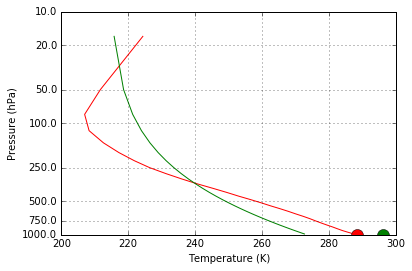

In [85]:
plot_sounding([col, re])

Some properties of the **radiative equilibrium** temperature profile:

- The surface is warmer than observed.
- The lower troposphere is colder than observed.
- Very cold air is sitting immediately above the warm surface.
- There is no tropopause, no stratosphere.

____________

## Radiative-Convective Equilibrium in the 30-layer model
____________

We recognize that the large drop in temperature just above the surface is unphysical. Parcels of air in direct contact with the ground will be warmed by mechansisms other than radiative transfer.

These warm air parcels will then become buoyant, and will convect upward, mixing their heat content with the environment.

We **parameterize** the statistical effects of this mixing through a **convective adjustment**. 

At each timestep, our model checks for any locations at which the **lapse rate** exceeds some threshold. Unstable layers are removed through an energy-conserving mixing formula.

This process is assumed to be fast relative to radiative heating. In the model, it is instantaneous.

In [86]:
rce = climlab.RadiativeConvectiveModel(adj_lapse_rate=6.)
print rce

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.RadiativeConvectiveModel'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



This model is exactly like our previous models, except for one additional subprocess called ``convective adjustment``. 

We passed a parameter ``adj_lapse_rate`` (in K / km) that sets the neutrally stable lapse rate -- in this case, 6 K / km.

This number is chosed to very loosely represent the net effect of **moist convection**. 

In [87]:
# Set our tuned absorptivity value
rce.subprocess.LW.absorptivity = eps

In [88]:
#  Run out to equilibrium
rce.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.99867375676 years.


In [89]:
#  Check for energy balance
rce.ASR - rce.OLR

array([  1.96076689e-06])

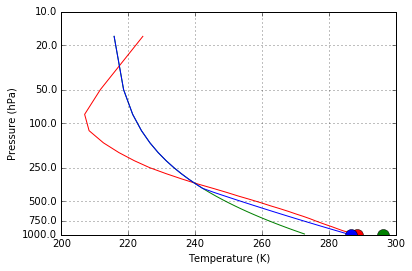

In [90]:
#  Make a plot to compare observations, Radiative Equilibrium, and Radiative-Convective Equilibrium
plot_sounding([col, re, rce])

Introducing convective adjustment into the model cools the surface quite a bit (compared to Radiative Equilibrium, in green here) -- and warms the lower troposphere. It gives us a MUCH better fit to observations.

But of course we still have no stratosphere.

The missing ingredient is **absorption of shortwave UV radiation by ozone**.

## The heating rates due to radiation and convection

In [91]:
#  Here we plotting the heating rates in K / day
degrees_per_day_atm = {'LW': (rce.subprocess['LW'].heating_rate['Tatm'] /
                                 rce.Tatm.domain.heat_capacity * 
                                 climlab.constants.seconds_per_day),
                       'SW': (rce.subprocess['SW'].heating_rate['Tatm'] /
                                 rce.Tatm.domain.heat_capacity * 
                                 climlab.constants.seconds_per_day),
                   'Convection': (rce.subprocess['convective adjustment'].adjustment['Tatm'] /
                                  rce.timestep * 
                                  climlab.constants.seconds_per_day)}
degrees_per_day_sfc = {'LW': (rce.subprocess['LW'].heating_rate['Ts'] / 
                                      rce.Ts.domain.heat_capacity *
                                      climlab.constants.seconds_per_day),
                        'SW': (rce.subprocess['SW'].heating_rate['Ts'] / 
                                      rce.Ts.domain.heat_capacity *
                                      climlab.constants.seconds_per_day),
                        'Convection': (rce.subprocess['convective adjustment'].adjustment['Ts'] /
                                       rce.timestep * 
                                       climlab.constants.seconds_per_day)}

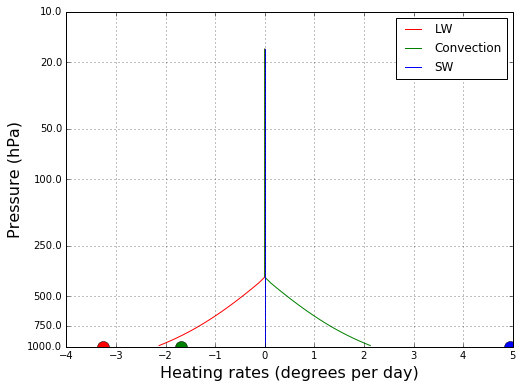

In [92]:
color_cycle=['r', 'g', 'b', 'y']

fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(111)
zstar = -np.log(rce.lev/climlab.constants.ps)
for i, item in enumerate(degrees_per_day_atm):
    ax.plot(degrees_per_day_atm[item], zstar, color=color_cycle[i], label=item)
for i, item in enumerate(degrees_per_day_sfc):
    ax.plot(degrees_per_day_sfc[item], 0, 'o', markersize=12, color=color_cycle[i])
yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10.])
ax.set_yticks(-np.log(yticks/1000.))
ax.set_yticklabels(yticks)
ax.set_xlabel('Heating rates (degrees per day)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.legend()
ax.grid()

What do we see here?

- SW radiation is acting to heat the surface strongly
- No SW heating in the atmosphere (assumed to be transparent)
- At the surface, there is a **balance** between **heat gain from SW radiation** and **heat loss from both LW radiation and convection**
- LW radiation is acting to **cool the troposphere**
- Convection is acting to **warm the troposphere**

Collectively the LW and SW radiation are trying to push the temperatures towards **radiative equilibrium** while the convection is moving heat from the surface to the troposphere.